# BI - Laboratorio 1
Santiago Casasbuenas - 202214932
Manuel Gomez - xxxxxx
Juan Pablo Castro - xxxxxx

## 0. Imports

In [23]:
%matplotlib inline

In [ ]:
# -------------------------------------------
# Librerías para manipulación y cálculo numérico
import numpy as np
import pandas as pd

# Configuración de pandas para visualizar más filas y columnas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

# -------------------------------------------
# Utilidades para guardar y cargar modelos
from joblib import dump, load

# -------------------------------------------
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------
# Herramientas de scikit-learn para preparación de datos y modelado
# División de datos, regresión lineal y creación de pipelines y transformaciones
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Métricas para evaluar el modelo de regresión
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------
# Funciones estadísticas adicionales
import scipy.stats as stats

# -------------------------------------------
# Librerías para análisis de datos
from ydata_profiling import ProfileReport

## 1. Carga de datos
En esta sección se explica cómo se carga el conjunto de datos que se utilizará a lo largo del laboratorio. Se suele emplear la función pd.read_csv (o funciones similares) para leer archivos con formato CSV, Excel u otros, permitiendo convertir la información en un DataFrame de pandas. Así, se asegura que la data esté disponible para realizar análisis exploratorio, procesamiento y modelado posterior.

In [25]:
# Carga de datos
star_df = pd.read_csv("./train_data.csv")

In [26]:
# Información general del dataset
star_df.shape

(4000, 18)

## 2. Entendimiento de los datos
Se realizará un perfilamiento de los datos utlizando pandas_profiling para obtener una visión general que nos permita identificar potenciales problemas en variables específicas y en las relaciones entre ellas. Después, se efectuará un análisis numérico a través de gráficas de dispersión e histogramas para estudiar la distribución y la correlación de las variables cuantitativas. Paralelamente, se llevará a cabo un análisis categórico utilizando histogramas para visualizar la variación y detectar outliers en las variables cualitativas. Además, se incluirá un análisis de calidad de los datos que evaluará la completitud, unicidad, consistencia y validez de la información disponible.


### 2.1 Primer análisis de variables numéricas y categoricas

#### 2.1.1 Análisis Numérico - Gráficas de dispersión e histogramas
En esta sección se explorará la distribución y relaciones de las variables numéricas del conjunto de datos. Se utilizarán gráficas de dispersión para visualizar la relación entre pares de variables de interés y detectar patrones o posibles outliers. Asimismo, se generarán histogramas para analizar la distribución de cada variable, permitiendo identificar sesgos o concentraciones inusuales. Estas visualizaciones serán fundamentales para entender el comportamiento de la data antes de proceder con transformaciones o modelado.


##### 2.1.1.1 Gráficas de dispersión

In [27]:
numericas = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field', 'clean', 'redshift', 'mjd', 'rowv', 'colv', 'objid']

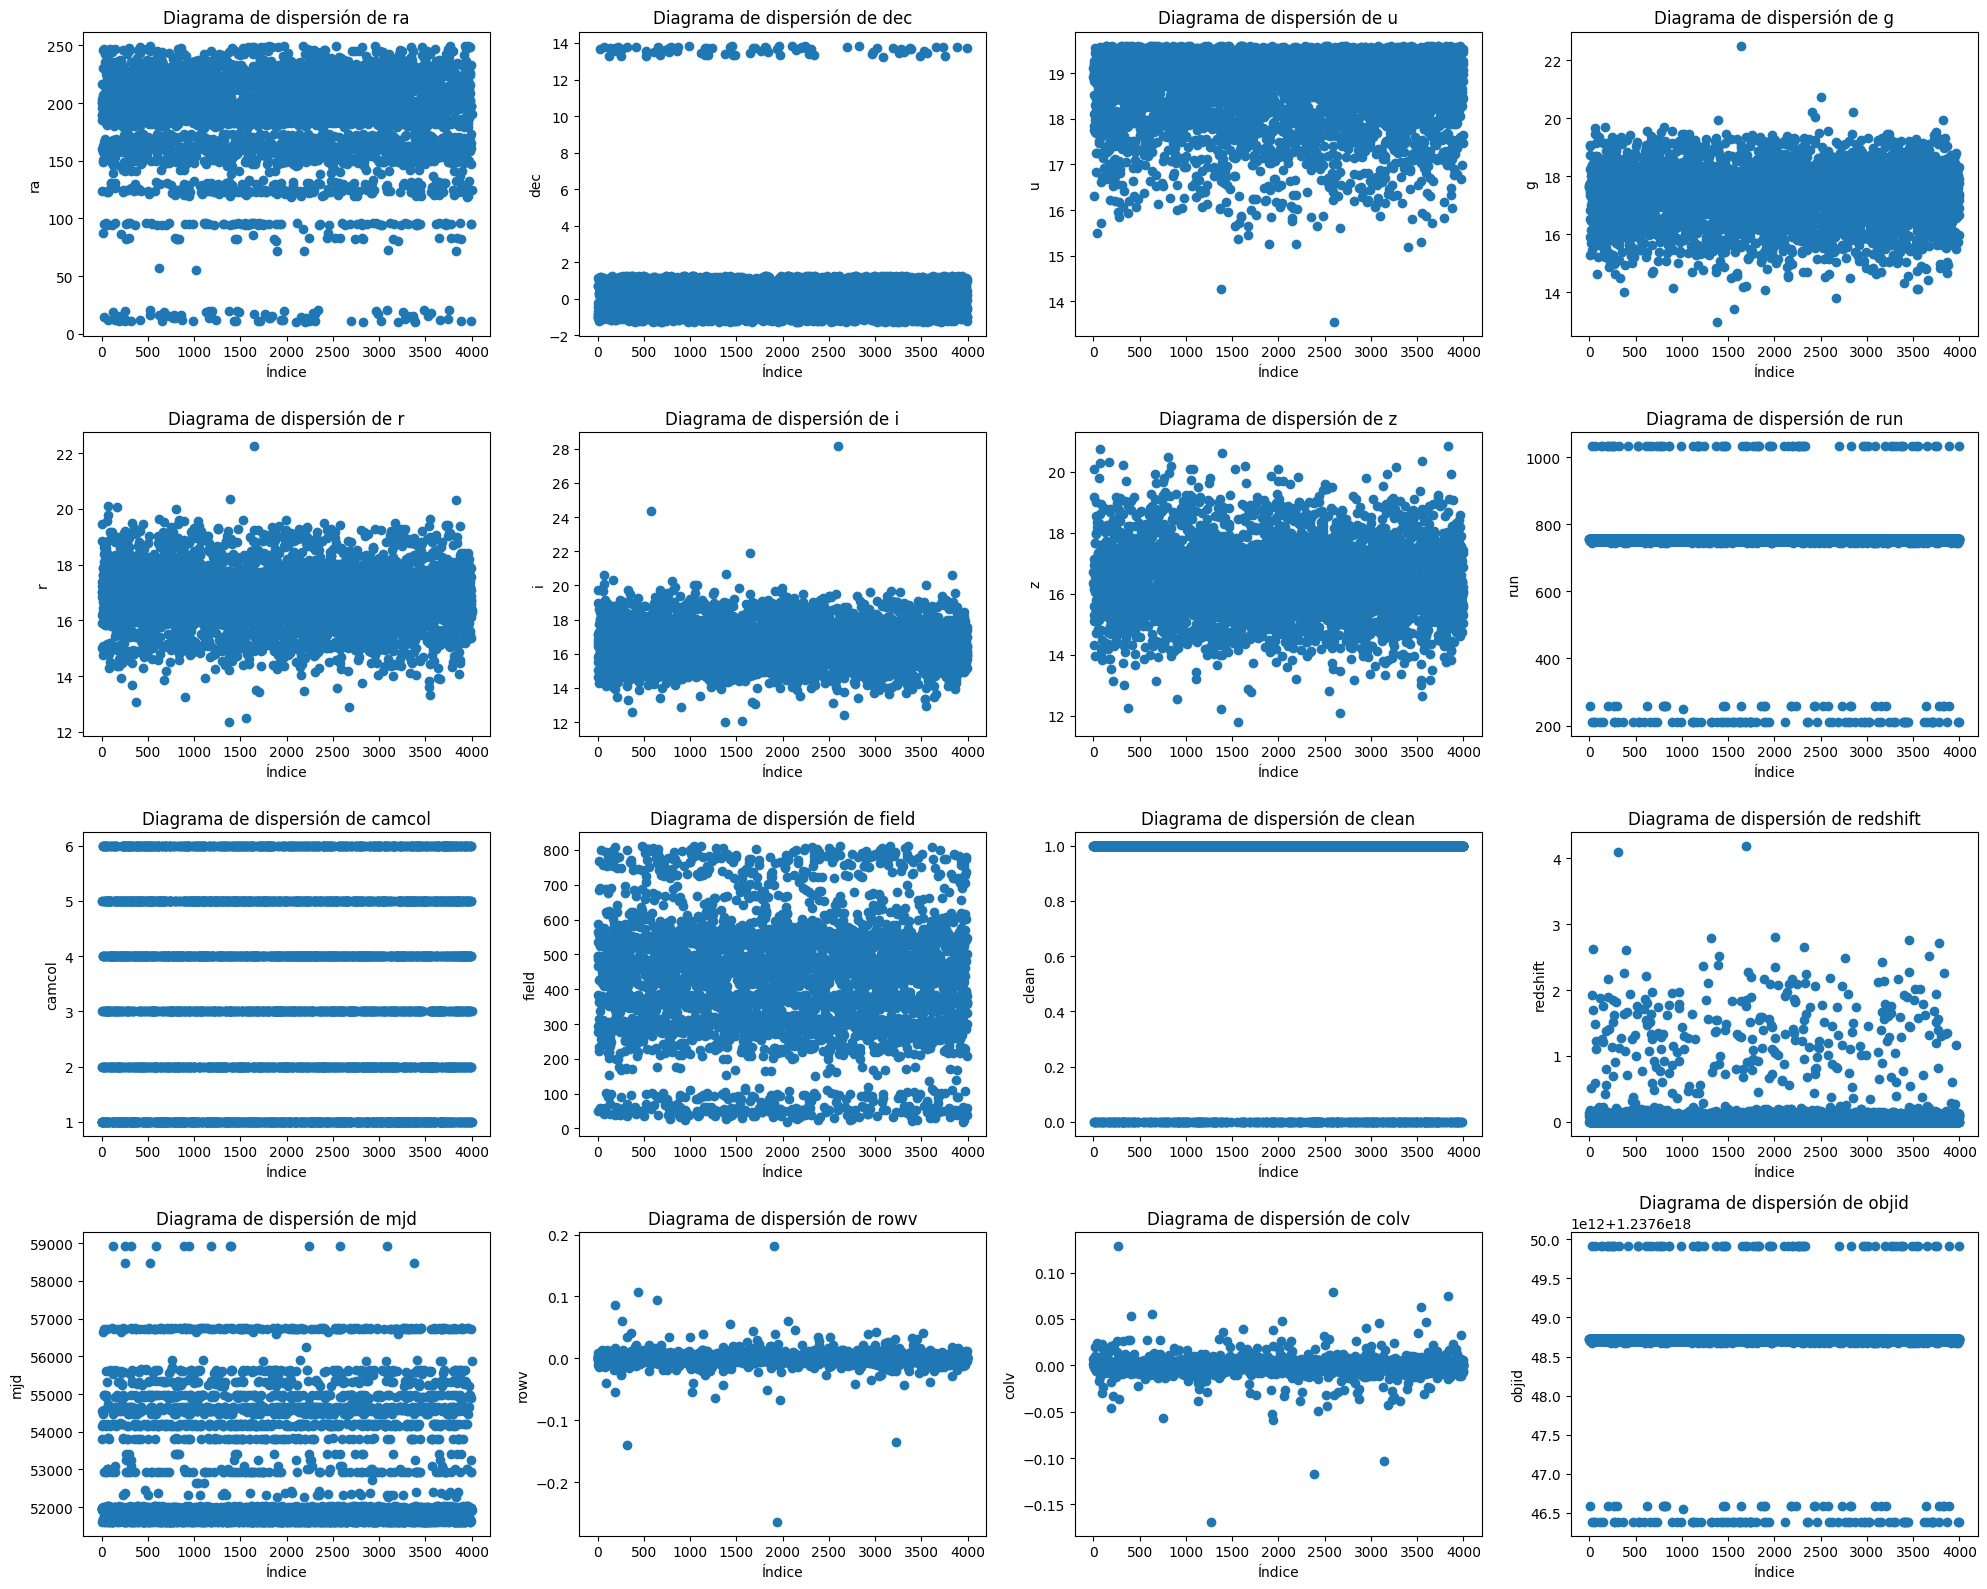

In [28]:
# Calcular el número de filas necesarias en base a columnas por fila
columnas_por_fila = 4
filas = int(np.ceil(len(numericas) / columnas_por_fila))
figura, ejes = plt.subplots(filas, columnas_por_fila, figsize=(columnas_por_fila * 5, filas * 4))
ejes = ejes.flatten()

# Graficar cada columna numérica en un subplot separado
for eje, columna in zip(ejes, numericas):
    eje.scatter(star_df.index, star_df[columna])
    eje.set_xlabel("Índice")
    eje.set_ylabel(columna)
    eje.set_title(f"Diagrama de dispersión de {columna}")

# Ocultar subplots extras
for eje in ejes[len(numericas):]:
    eje.set_visible(False)

plt.tight_layout()
plt.show()


##### 2.1.1.2 Histogramas

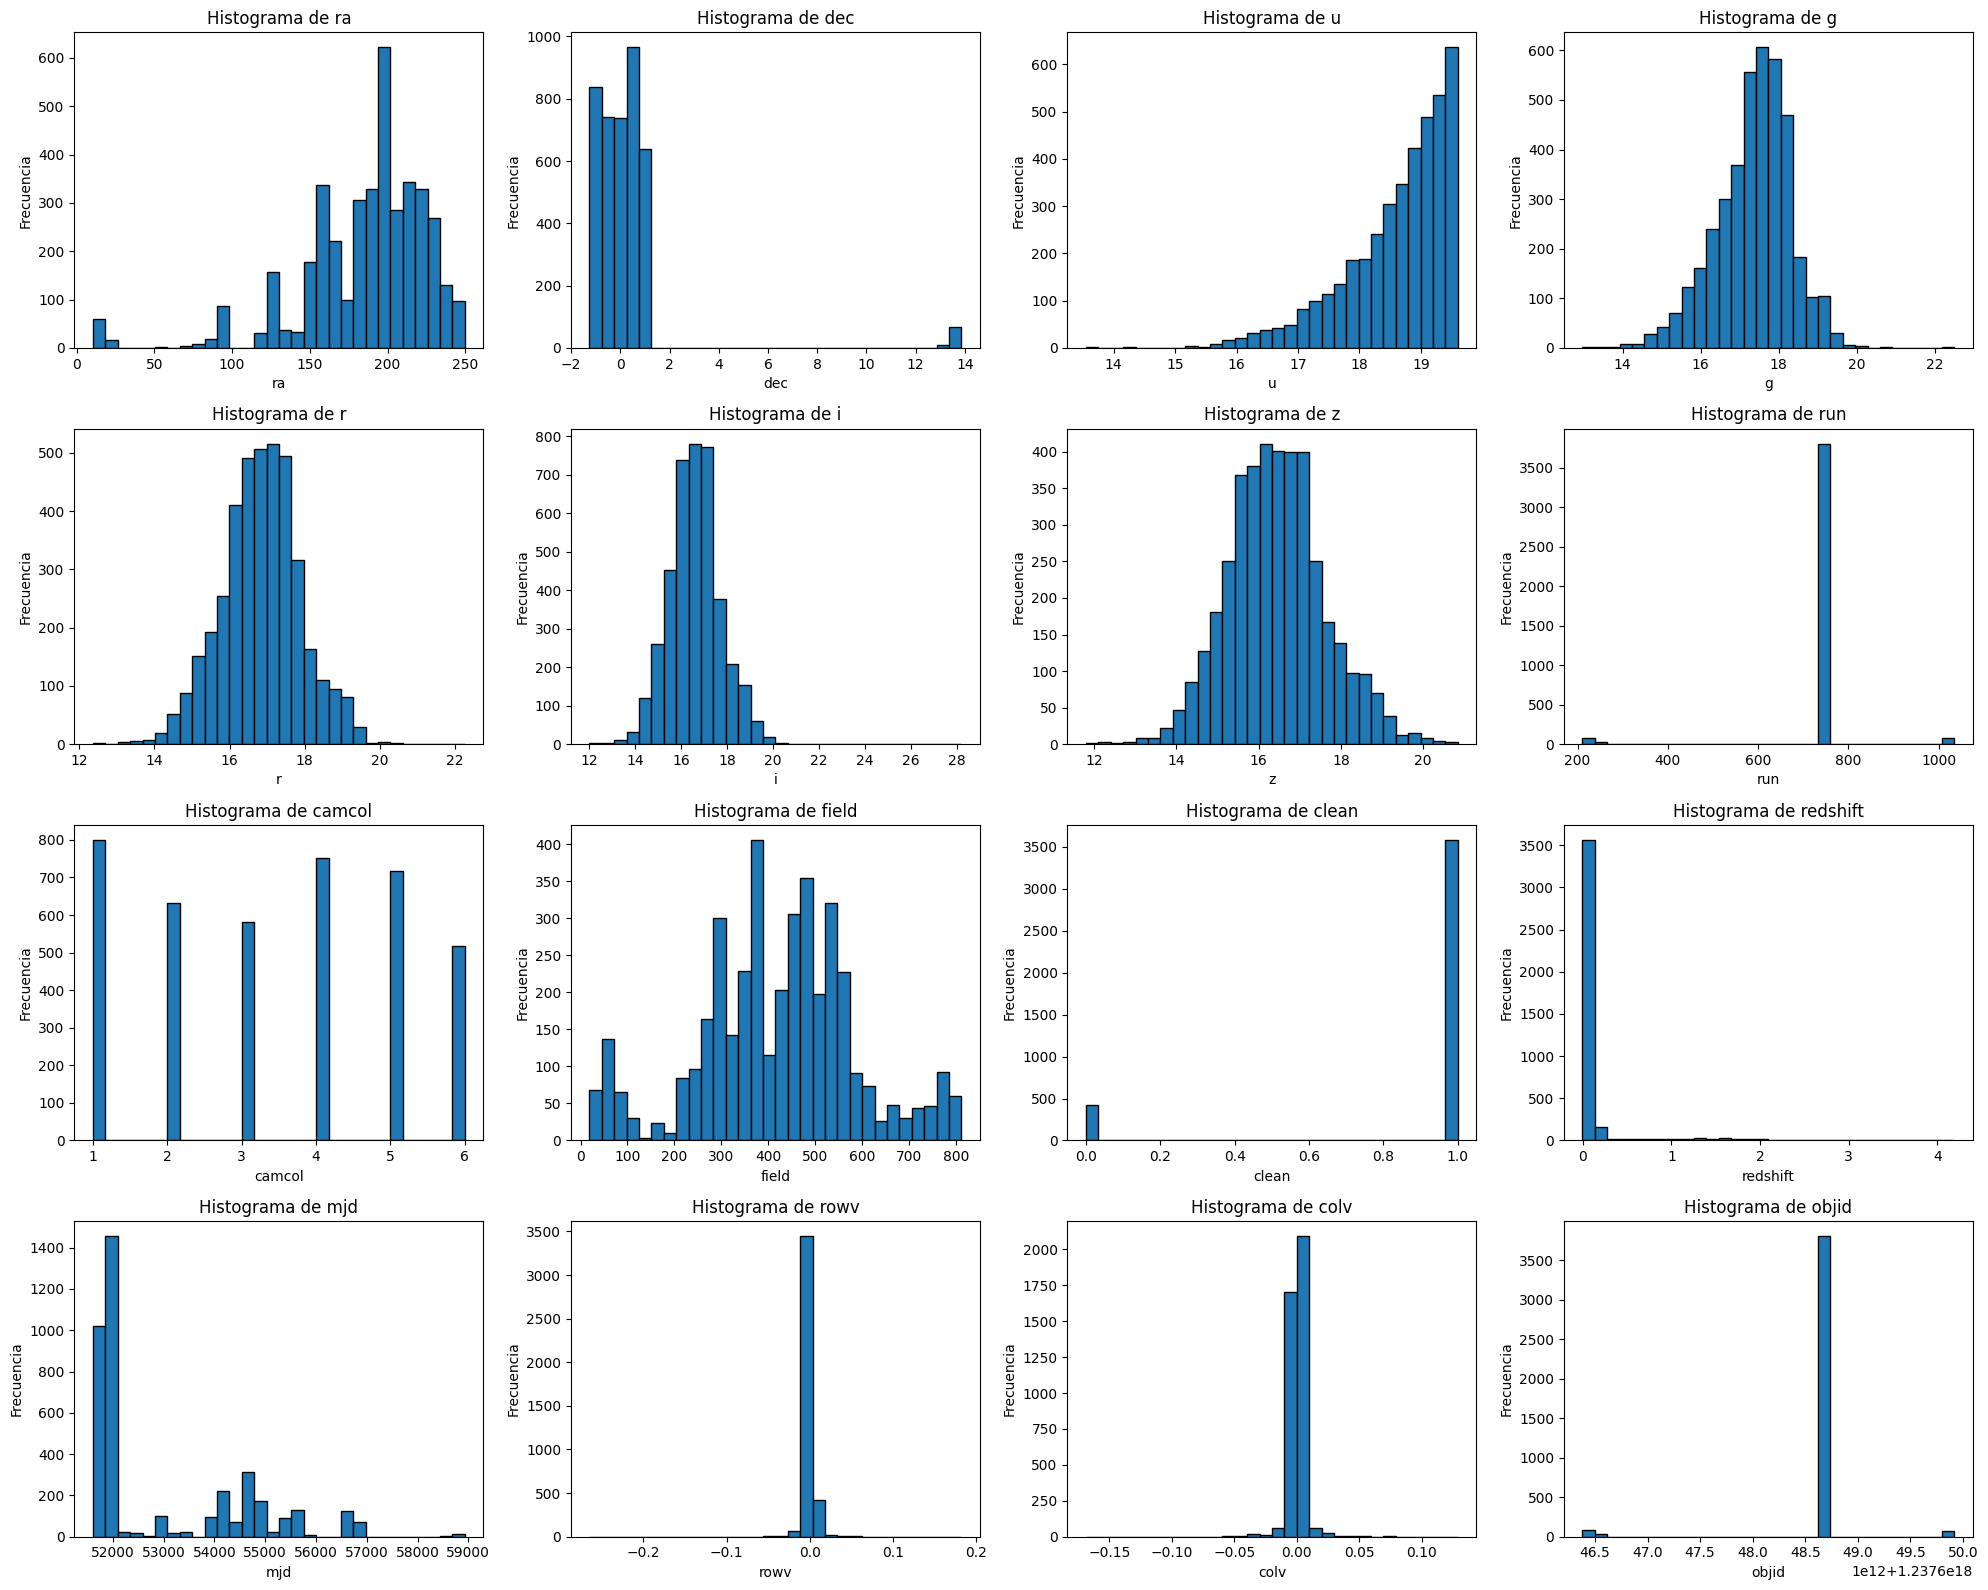

In [29]:
# Generar histogramas para cada variable numérica
filas_histo = int(np.ceil(len(numericas) / columnas_por_fila))
fig, axes_hist = plt.subplots(filas_histo, columnas_por_fila, figsize=(columnas_por_fila * 5, filas_histo * 4))
axes_hist = axes_hist.flatten()

for ax, col in zip(axes_hist, numericas):
    ax.hist(star_df[col], bins=30, edgecolor='black')
    ax.set_title(f"Histograma de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

# Ocultar los subplots vacíos si existen
for ax in axes_hist[len(numericas):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

##### 2.1.1.3 Conlcusiones iniciales sobre las variables numéricas

Inicialmente, algunas de las variables muestran cantidades significativas de valores anómalos a simple vista. Se pueden apreciar estas anomalías en variables como ra, dec, run y objid. Se podría pensar que clean también cuenta con valores anómalos, pero, como se describe en el diccionario de datos, esta variable sólo tiene valores equivalentes a 0 o 1.

#### 2.1.2 Análisis Categórico - Histograma

En esta sección se llevará a cabo el análisis categórico utilizando boxplots. Se busca visualizar la distribución de las variables categóricas y detectar posibles outliers o patrones particulares en los grupos. Esto permitirá identificar discrepancias, validar la consistencia de la información y determinar si es necesario realizar alguna transformación o limpieza de los datos antes de continuar con el análisis o modelado.

##### 2.1.2.1 Histograma

In [30]:
categoricas = ['class']

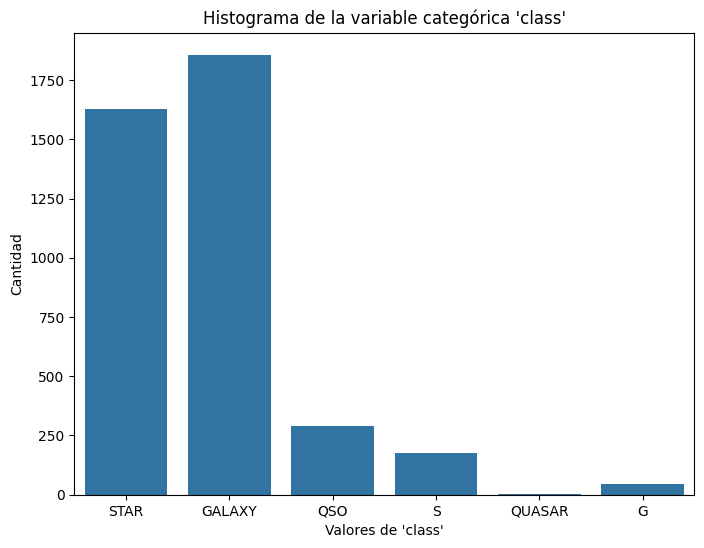

In [31]:
plt.figure(figsize=(8,6))
sns.countplot(data=star_df, x='class')
plt.xlabel("Valores de 'class'")
plt.ylabel("Cantidad")
plt.title("Histograma de la variable categórica 'class'")
plt.show()

##### 2.1.2.2 Conclusiones iniciales sobre variables categóricas
Nos damos cuenta que, aunque en el diccionario de los datos se expresa que solo deben existir los valores "STAR", "GALAXY" y "QSO", estamos observando otros valores tales como "S", "QUASAR" y "G"

### 2.2 Perfilamiento con pandas_profiling
En esta sección se utilizará pandas_profiling para generar un informe detallado del dataset. El reporte incluirá análisis estadísticos exploratorios como la distribución de las variables, la identificación de valores nulos, la detección de posibles outliers y la evaluación de la correlación entre las variables. Esto permitirá obtener una visión aún más especifica de la calidad y estructura de los datos que a lo mejor no se alcanza a visualizar con solo gráficas tradicionales.

In [32]:
# Perfilamiento de los datos a través de ydata_profiling
# profile = ProfileReport(star_df, title='StarAlpes Data - Profiling Report', explorative=True)
# profile

#### 2.2.1 Análisis del perfilamiento
##### 2.2.1.1 Alertas encontradas por el programa
Se obtuvieron 13 alertas. En estas, se destacan 3 aspectos importantes.

1. **Filas Duplicadas**
    - **Problema:** Hay 17 filas duplicadas en el conjunto de datos.

    - **Acción:** Se tomará la acción de eliminar estos duplicados para asegurar la integridad del análisis y evitar sesgos en los modelos de aprendizaje automático.

In [33]:
# Mostrar todas las filas duplicadas en el DataFrame
filas_duplicadas = star_df[star_df.duplicated(keep=False)]
print(filas_duplicadas)

# Contar la cantidad de filas duplicadas (considerando solo la primera aparición como no duplicada)
cantidad_duplicados = star_df.duplicated().sum()
print("\n----------------------------------------------------")
print(f"Cantidad de filas duplicadas: {cantidad_duplicados}")
print("------------------------------------------------------")

                    objid          ra       dec         u         g         r  \
88    1237648703513428079  206.374167 -0.781673  18.28101  17.18856  16.70175   
109   1237648721231609897  182.015940 -0.116600  17.96686  16.91550  16.75447   
114   1237646382079606869   94.679499  0.842321  18.47695  16.94897  16.68126   
299   1237648721756225804  154.036159  0.417930  19.50457  18.08980  17.29931   
629   1237648720687988788  166.623017 -0.546630  19.55528  17.73928  16.86703   
642   1237648720715710772  229.932143 -0.607750  18.34448  17.39741  17.08713   
718   1237648721789780467  230.664376  0.229439  19.48961  18.21590  17.50523   
719   1237648721788993889  228.864817  0.317359  18.88618  17.66549  17.09694   
856   1237648705679065271  247.896821  0.990909  16.74659  15.61752  15.43460   
897   1237646382079672642   94.883887  0.990686  17.03847  15.47224  15.10297   
1231  1237648720163832016  195.688105 -0.868582  19.20444  18.01077  17.32575   
1523  1237648705679065271  2

2. **Alta Correlación entre Variables**
    - **Problema:** Varias variables muestran alta correlación con otras, lo que puede indicar redundancia en la información. Se destacan entre ellas las siguientes similitudes:
        - `camcol` y `dec`
        - `dec` con `camcol` y otro campo
        - `field` y `ra`
        - `g`, `i`, `r`, `u`, `z` están altamente correlacionadas entre sí
        - `objid` con `dec` y otro campo
        - `run` y `objid`

    - **Acción:** En este se tomará la acción de tomar las variables que se consideren más importantes para resolver el problema del negocio. Por ejemplo: g, i, r, u, z todas hacen referencia a la magnitud del objeto, pero cada una representa un filtro distinto, debemos revisar la correlación entre la variable objetivo y estas y determinar cuales tienen una mayor correlación.

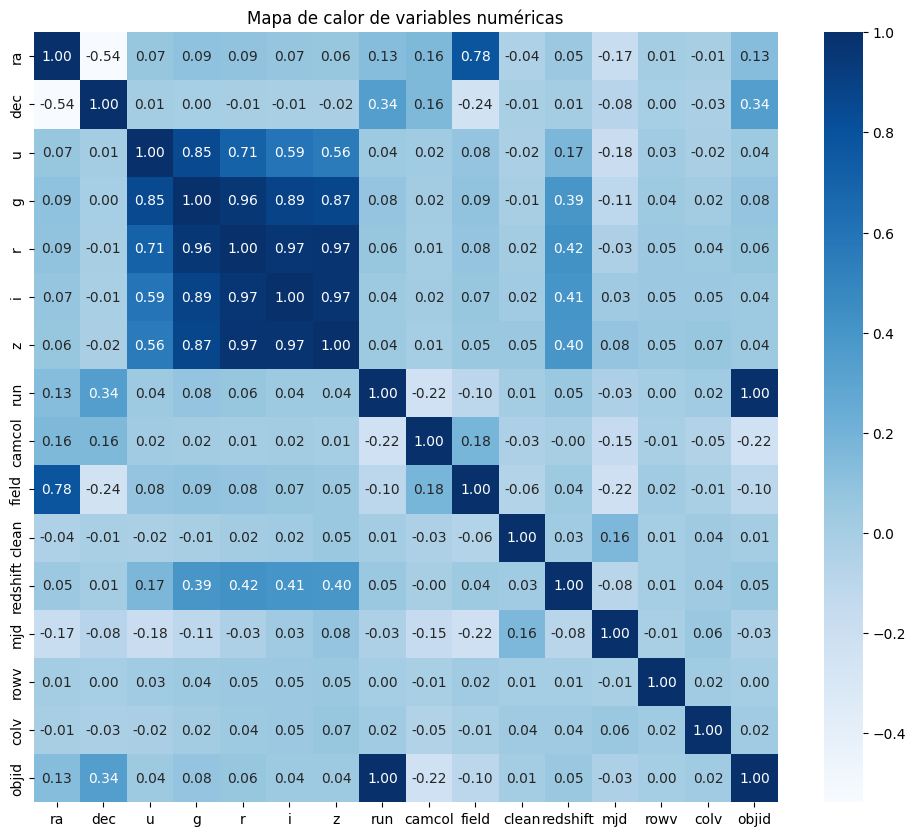

In [34]:
corr_matrix = star_df[numericas].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Mapa de calor de variables numéricas")
plt.show()

3. **Desbalance en 'clean'**
    - **Problema:** La varibale `clean`, que indica si la fotometría del objeto es limpia está desbalanceada (51.7%).
    
    - **Acción:** En este caso, se tomara la acción de retirar aquellos registros donde donde se indique que la fotometría no es limpia, ya que el diccionario nos indica que aquellas que no son limpias, no son confiables. 

In [35]:
tabla_clean = star_df['clean'].value_counts().reset_index()
tabla_clean.columns = ['Valor de clean', 'Conteo']
tabla_clean

,Valor de clean,Conteo
0,1,3582
1,0,418


### 2.3 Análisis de Calidad

En esta sección se evaluará la calidad de los datos mediante el análisis de los siguientes aspectos clave:
- **Completitud:** Se revisarán las variables para identificar posibles valores nulos o ausentes y así determinar la integridad de la información.

- **Unicidad:** Se verificará la existencia de registros duplicados, lo que podría afectar la fiabilidad de los análisis posteriores.

- **Consistencia:** Se analizarán las discrepancias entre los datos, buscando inconsistencias que indiquen errores o fallos en la recolección.

- **Validez:** Se comprobará que los valores cumplan con los formatos y restricciones esperados, asegurando que los datos sean confiables y relevantes para el problema a resolver.


#### 2.3.1 Análisis de Completitud

In [36]:
# Análisis de completitud: conteo y porcentaje de valores nulos en cada columna
faltantes = star_df.isnull().sum()
porcentaje_faltante = 100 * star_df.isnull().sum() / len(star_df)
completitud = pd.DataFrame({
    "Valores faltantes": faltantes,
    "Porcentaje (%)": porcentaje_faltante
})
print(completitud)

          Valores faltantes  Porcentaje (%)
objid                     0             0.0
ra                        0             0.0
dec                       0             0.0
u                         0             0.0
g                         0             0.0
r                         0             0.0
i                         0             0.0
z                         0             0.0
run                       0             0.0
camcol                    0             0.0
field                     0             0.0
score                     0             0.0
clean                     0             0.0
class                     0             0.0
redshift                  0             0.0
mjd                       0             0.0
rowv                      0             0.0
colv                      0             0.0



La completitud de los datos es muy buena, ya que no se han reportado valores nulos en ninguna de las columnas del DataFrame, lo que indica que la información está completa y lista para el análisis.


#### 2.3.2 Análisis de Unicidad

In [37]:
# Análisis de unicidad en español

# Número total de filas
total_filas = star_df.shape[0]
print("Número total de filas:", total_filas)

# Número de filas duplicadas
filas_duplicadas = star_df.duplicated().sum()
print("Número de filas duplicadas:", filas_duplicadas)
print(f"Porcentaje de filas duplicadas: {100 * filas_duplicadas / total_filas:.2f}%")

# Análisis de unicidad por columna: número de valores únicos en cada una
print("\nNúmero de valores únicos por columna:")
unicidad = star_df.nunique()
print(unicidad)

Número total de filas: 4000
Número de filas duplicadas: 17
Porcentaje de filas duplicadas: 0.42%

Número de valores únicos por columna:
objid       3983
ra          3983
dec         3983
u           3952
g           3953
r           3963
i           3959
z           3968
run            7
camcol         6
field        663
score       1563
clean          2
class          6
redshift    3932
mjd          183
rowv        3979
colv        3978
dtype: int64


El análisis de unicidad revela distintos comportamientos entre las variables del dataset:

- Algunas variables, especialmente las categóricas o que representan atributos con pocos niveles (como "run", "camcol", "clean" y "class"), muestran un número de valores únicos muy bajo, lo cual es esperado dado que representan categorías o indicadores con datos limitados.

- Por otro lado, variables que se esperarían ser prácticamente únicas en cada registro, como "objid", presentan algunas duplicaciones (por ejemplo, "objid" cuenta con 3983 valores únicos de 4000 registros). Esto indica la presencia de 17 filas duplicadas, lo que debe considerarse para garantizar la integridad de los datos al utilizar claves identificadoras.

- En resumen, es importante validar que la duplicidad observada en variables que se esperan tener alta unicidad sea justificada o, de lo contrario, proceder a la limpieza de los datos para evitar problemas en análisis o modelados futuros.

#### 2.3.3 Análisis de Consistencia

In [38]:
# Análisis de consistencia

# a) Verificar que la columna 'clean' solo contenga valores 0 y 1 (según el diccionario de datos)
valores_clean = star_df['clean'].unique()
print("Valores únicos en 'clean':", valores_clean)
if set(valores_clean).issubset({0, 1}):
    print("La columna 'clean' es consistente (solo contiene 0 y 1).")
else:
    print("¡Atención! La columna 'clean' contiene valores inconsistentes:", valores_clean)

# b) Verificar la consistencia de la columna 'class' frente a los valores esperados: 'STAR', 'GALAXY', 'QSO'
valores_class = star_df['class'].unique()
print("\nValores únicos en 'class':", valores_class)
valores_esperados = {'STAR', 'GALAXY', 'QSO'}
inconsistentes = [val for val in valores_class if val not in valores_esperados]
if not inconsistentes:
    print("La columna 'class' es consistente.")
else:
    print("La columna 'class' contiene valores inconsistentes. Valores encontrados:", inconsistentes)

# c) Verificar que la columna 'score' se encuentre en el rango esperado [0, 1]
score_min = star_df['score'].min()
score_max = star_df['score'].max()
print(f"\nRango de 'score': {score_min} - {score_max}")
if score_min < 0 or score_max > 1:
    print("La columna 'score' tiene valores fuera del rango esperado [0,1].")
else:
    print("La columna 'score' es consistente.")

Valores únicos en 'clean': [1 0]
La columna 'clean' es consistente (solo contiene 0 y 1).

Valores únicos en 'class': ['STAR' 'GALAXY' 'QSO' 'S' 'QUASAR' 'G']
La columna 'class' contiene valores inconsistentes. Valores encontrados: ['S', 'QUASAR', 'G']

Rango de 'score': 0.3019117 - 0.961145
La columna 'score' es consistente.



- La columna **clean** es consistente, ya que solo se encontraron los valores válidos 0 y 1.
- La columna **class** presenta inconsistencias; aunque se esperaban únicamente los valores "STAR", "GALAXY" y "QSO", se han detectado valores adicionales como "S", "QUASAR" y "G". Es recomendable revisar y limpiar estos datos para asegurar la calidad del análisis.
- La columna **score** se encuentra en el rango esperado [0, 1], lo que indica que cumple con las restricciones definidas.

En resumen, se requiere atención en la columna **class** para alinear sus valores con lo especificado en el diccionario de datos.


#### 2.3.4 Análisis de Validez

In [39]:
# Análisis de validez

print("Análisis de validez:")

# Validación de 'score': debe estar en el rango [0, 1]
score_min = star_df["score"].min()
score_max = star_df["score"].max()
print("Rango de 'score':", score_min, "-", score_max)
if (star_df["score"] < 0).any() or (star_df["score"] > 1).any():
    print("Error: La columna 'score' contiene valores fuera del rango [0,1].")
else:
    print("La columna 'score' es válida.")

# Validación de 'ra' (ascensión recta): se espera que esté dentro de [0, 360]
ra_min = star_df["ra"].min()
ra_max = star_df["ra"].max()
print("\nRango de 'ra':", ra_min, "-", ra_max)
if (star_df["ra"] < 0).any() or (star_df["ra"] > 360).any():
    print("Error: La columna 'ra' contiene valores fuera del rango [0,360].")
else:
    print("La columna 'ra' es válida.")

# Validación de 'dec' (declaración): se espera que esté dentro de [-90, 90]
dec_min = star_df["dec"].min()
dec_max = star_df["dec"].max()
print("\nRango de 'dec':", dec_min, "-", dec_max)
if (star_df["dec"] < -90).any() or (star_df["dec"] > 90).any():
    print("Error: La columna 'dec' contiene valores fuera del rango [-90,90].")
else:
    print("La columna 'dec' es válida.")

# Validación de 'mjd': se muestran estadísticas descriptivas para evaluar su razonabilidad
print("\nEstadísticas descriptivas de 'mjd':")
print(star_df["mjd"].describe())

Análisis de validez:
Rango de 'score': 0.3019117 - 0.961145
La columna 'score' es válida.

Rango de 'ra': 10.46974318 - 249.7583133
La columna 'ra' es válida.

Rango de 'dec': -1.252763102 - 13.85401031
La columna 'dec' es válida.

Estadísticas descriptivas de 'mjd':
count     4000.000000
mean     52957.124750
std       1601.148131
min      51608.000000
25%      51821.000000
50%      51986.000000
75%      54468.000000
max      58932.000000
Name: mjd, dtype: float64



- La columna **score** se encuentra en el rango esperado [0, 1], lo que indica que sus valores son válidos.
- La columna **ra** está dentro del rango [0, 360], confirmando que la ascensión recta cumple con las restricciones.
- La columna **dec** también se encuentra en el rango esperado [-90, 90], sin valores aberrantes.
- En general, las estadísticas descriptivas y los rangos evaluados muestran que las principales variables numéricas cumplen con los criterios de validez definidos. Esto permite continuar con el análisis y modelado sin requerir transformaciones adicionales relacionadas con la validez de estos datos.


## 3. Preparación de los Datos

En esta etapa se busca limpiar y transformar el dataset para asegurar que la información sea confiable y esté lista para el modelado. Las principales acciones son:

- Verificar y eliminar valores nulos, en caso de existir.
- Detectar y remover filas duplicadas, ya que se han identificado 17 duplicados, para evitar el sesgo en el análisis.
- Identificar y tratar valores atípicos u outliers en variables numéricas revisadas en los diagramas de dispersión e histogramas (por ejemplo, en variables como "ra", "dec", "run" y "objid").
- Revisar la consistencia de los datos, especialmente en variables categóricas:
    - La columna "class" presenta valores inesperados (por ejemplo, "S", "QUASAR" y "G") frente a los valores esperados ("STAR", "GALAXY" y "QSO"). Se planea realizar una corrección o recodificación de esta variable. Además, se planea hacer OneHotEncoding para añadir la varibale class a las variables numéricas.
    - La variable "clean" se utilizará para eliminar los registros con fotometría no confiable (es decir, aquellos valores que indiquen que la fotometría no es limpia).
- Evaluar las constantes y alta correlación entre algunas variables (por ejemplo, las magnitudes "u", "g", "r", "i", "z") para determinar cuáles se mantendrán o se agruparán en procesos de selección de características.

Estos pasos asegurarán la calidad del dataset, eliminando ruidos y errores que puedan afectar el análisis y el rendimiento del modelo.

### 3.1 Eiminar valores nulos

In [40]:
# Eliminamos los valores nulos del DataFrame (aunque en este caso no hay valores nulos)
star_df.dropna(inplace=True)
print("Dimensiones del DataFrame tras eliminar valores nulos:", star_df.shape)

Dimensiones del DataFrame tras eliminar valores nulos: (4000, 18)


### 3.2 Eliminar datos duplicados

In [41]:
# Eliminamos los datos duplicados, manteniendo la primera aparición de cada registro
star_df.drop_duplicates(inplace=True)
print("Dimensiones del DataFrame tras eliminar datos duplicados:", star_df.shape)

Dimensiones del DataFrame tras eliminar datos duplicados: (3983, 18)


### 3.3 Eliminar valores "no confiables" de la variable clean

In [42]:
# Filtrar el DataFrame eliminando registros donde 'clean' no sea 1 (no confiables)
star_df = star_df[star_df['clean'] == 1]
print("Dimensiones del DataFrame después de eliminar registros no confiables:", star_df.shape)

Dimensiones del DataFrame después de eliminar registros no confiables: (3566, 18)


### 3.4 Quitar valores inconsistentes de variable class

In [43]:
# Reemplazar valores en la columna 'class'
star_df['class'] = star_df['class'].replace({'S': 'STAR', 'G': 'GALAXY', 'QUASAR': 'QSO'})

# Verificar que dentro de 'class' solo existan los tres valores esperados
class_counts = star_df['class'].value_counts()

# Verificar los valores únicos actualizados
print("Valores únicos actualizados en 'class':", star_df['class'].unique())

Valores únicos actualizados en 'class': ['STAR' 'GALAXY' 'QSO']


#### 3.4.1 Aplicar OneHotEncoding a la variable "class"

In [44]:
# Aplicar OneHotEncoding para la variable 'class'
star_df = pd.get_dummies(star_df, columns=['class'], prefix='class')
star_df.head()

,objid,ra,dec,u,g,r,i,z,run,camcol,field,score,clean,redshift,mjd,rowv,colv,class_GALAXY,class_QSO,class_STAR
0,1237648722306924571,185.574486,0.701402,19.11034,17.62099,17.03464,16.82993,16.71711,756,5,466,0.864145,1,8.780529e-05,54140,0.002418,0.001363,False,False,True
1,1237648720167436418,203.801841,-0.853906,18.90957,17.62940,17.01465,16.62059,16.35239,756,1,588,0.816541,1,8.619995e-02,51955,0.008650,0.007056,True,False,False
2,1237648720685105352,160.034264,-0.421626,19.26340,17.67693,16.82551,16.42307,16.13864,756,2,295,0.870381,1,1.330486e-01,51913,0.003938,-0.002028,True,False,False
3,1237648703510937836,200.807373,-0.682024,18.82022,17.77765,17.38575,17.11128,16.93540,752,2,382,0.867801,1,8.636355e-02,51959,0.001839,0.001160,True,False,False
4,1237648720161275992,189.792404,-1.001480,18.91391,19.05355,19.46278,19.75660,20.09613,756,1,494,0.833824,1,-4.090000e-08,54562,0.001929,-0.000465,False,False,True


### 3.5 Poner como valor máximo 2.5 en redshift  
Se aplica un límite superior de 2.5 a los valores de la variable objetivo con el fin de que a cualquier valor **mayor** a 2.5 se le asigne un valor de 2.5. Esto garantiza que los valores extremos no afecten el comportamiento posterior del modelo.

In [45]:
star_df["redshift"] = star_df["redshift"].clip(upper=2.5)

### 3.6 Escoger variables con las cuales se planea entrenar el modelo

Se eligieron las variables "u", "g" e "i" porque miden el brillo del objeto cuando se ve a través de distintos filtros, lo que ayuda a notar diferencias en la luz. Esto es importante para saber qué tipo de objeto se está observando. Por otro lado, las variables "class_GALAXY", "class_QSO" y "class_STAR" vienen de transformar la variable original "class" en varias columnas con valores de 0 o 1 (OneHotEncoding). Así, el modelo comprende mejor las diferencias entre galaxias, cuásares y estrellas. Al juntar las medidas de brillo y la clasificación en columnas separadas, se esera crear una base sólida para predecir o clasificar los objetos.


In [47]:
features = ['u', 'g', 'i', 'class_GALAXY', 'class_QSO', 'class_STAR']

#### 3.6.1 Mapa de calor de relación entre variables escogidas

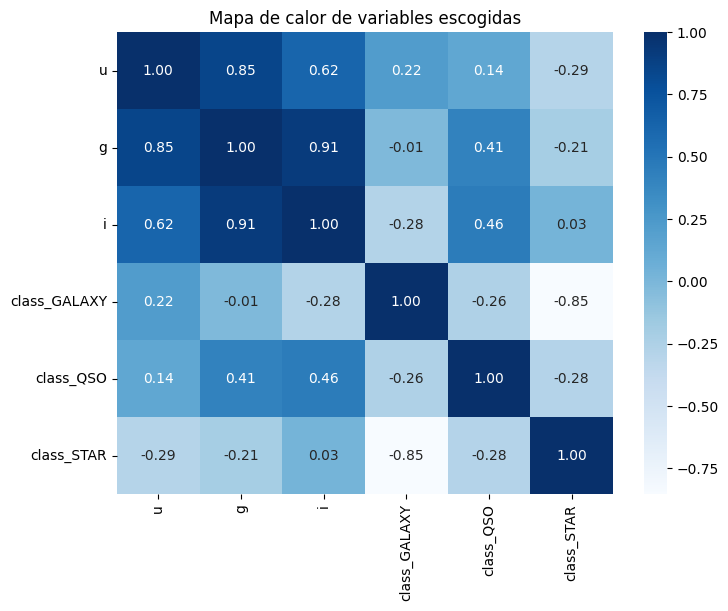

In [49]:
corr_features = star_df[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_features, annot=True, fmt=".2f", cmap="Blues")
plt.title("Mapa de calor de variables escogidas")
plt.show()

## 4. Entrenamiento del modelo


En esta sección se llevará a cabo el entrenamiento del modelo de regresión. Se espera consolidar el preprocesamiento realizado previamente y configurar un pipelines para ajustar la relación entre las características seleccionadas y la variable objetivo. Además, se contemplará la división de los datos en conjuntos de entrenamiento y prueba para evaluar el desempeño del modelo.


### 4.1 Particionamiento del conjunto de datos en entrenamiento y prueba

Se divide el conjunto de datos en dos porciones: una de entrenamiento para ajustar los parámetros del modelo y otra de prueba para evaluar su desempeño. Este proceso permite estimar el error real del modelo y prevenir problemas de sobreajuste.

In [50]:
X = star_df[features]
y = star_df["redshift"]

# División en 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}")
print(f"Tamaño de prueba: {X_test.shape}")

Tamaño de entrenamiento: (2852, 6)
Tamaño de prueba: (714, 6)


### 4.2 Implementar y ajustar scaler


El scaler se utiliza para ajustar las variables numéricas a escalas similares, evitando que valores con magnitudes distintas influyan desproporcionadamente en el modelo. Al “ajustar” este scaler, se calculan estadísticas (como la media y la desviación estándar) a partir de los datos de entrenamiento, y luego se aplican para transformar tanto el conjunto de entrenamiento como el de prueba, homogenizando el rango de los valores.


In [51]:
scaler = StandardScaler()

In [52]:
# Ajustar el scaler en los datos de entrenamiento y transformar ambos conjuntos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.3 Creación del Pipeline


Los pipelines se utilizan para encadenar pasos de preprocesamiento y modelado en un solo flujo de trabajo. Esto facilita la reproducibilidad, pues cada nuevo conjunto de datos pasa por las mismas transformaciones antes de llegar al modelo. Además, simplifica la implementación y reduce el riesgo de errores al mantener todos los pasos (escalado, transformación, entrenamiento del modelo, etc.) unificados.


In [53]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [54]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

### 4.4 Revisar coeficientes de las variables

Los coeficientes de las variables en un modelo de regresión permiten entender cómo cada característica influye, en promedio, sobre la variable objetivo. Si un coeficiente es positivo, indica que, al aumentar esa característica (mientras las demás permanecen fijas), el valor de la variable objetivo también tiende a aumentar. Si es negativo, sucede lo contrario. Esto sirve para interpretar y explicar de forma cuantitativa la relación entre las variables de entrada y la respuesta.


In [55]:
pd.DataFrame({"columns": features, "coef": pipeline["model"].coef_})

,columns,coef
0,u,0.003067
1,g,-0.009204
2,i,0.027599
3,class_GALAXY,-0.056915
4,class_QSO,0.291081
5,class_STAR,-0.103738



Los coeficientes indican cómo cambia el valor promedio de “redshift” cuando cada variable aumenta en una unidad, manteniendo constantes las demás. Un coeficiente negativo (por ejemplo, en “g” o “class_STAR”) sugiere que, a menor valor de esa variable, el “redshift” tiende a decreser. Por el contrario, un coeficiente positivo implica que el “redshift” aumenta conforme decrece la variable (por ejemplo, en “u” si resultara positivo). Así, los coeficientes ayudan a entender el efecto individual de cada filtro de magnitud (“u”, “g”, “i”) y la pertenencia a cada clase (“class_GALAXY”, “class_QSO”, “class_STAR”) sobre la variable objetivo.

### 4.5 Revisar el intercepto del pipeline


El intercepto representa el valor de la variable objetivo cuando todas las características se encuentran en cero. Revisarlo permite entender la línea base del modelo y apreciar cuánta contribución agrega cada coeficiente al predecir la variable de interés.

In [56]:
pipeline["model"].intercept_

0.14272548197709692

Conlcuir sobre el valor obtenido en el intercepto TODO: @MrRobot138

### 4.6 La Regresión Lineal

Explicar paraque se hace la regresión lineal TODO: @MrRobot138

In [57]:
regression = LinearRegression()
regression.fit(X_train_scaled, y_train)

# Predicción en los datos de prueba
y_pred = regression.predict(X_test_scaled)

## 5 Evaluación de Resultados

### 5.1 Evaluación Cuantitativa




La evaluación cuantitativa se utiliza para medir el rendimiento del modelo de regresión mediante métricas específicas. Estas métricas incluyen:

- **MAE (Mean Absolute Error):** Promedio de los errores absolutos entre las predicciones y los valores reales. Indica, en promedio, cuánto se desvía la predicción del valor real.
- **MSE (Mean Squared Error):** Promedio de los errores al cuadrado entre las predicciones y los valores reales. Penaliza más los errores grandes y es útil para identificar grandes desviaciones.
- **R² (Coeficiente de Determinación):** Proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Indica qué tan bien se ajusta el modelo a los datos.

Estas métricas permiten evaluar la precisión y la eficacia del modelo, ayudando a identificar áreas de mejora y a comparar diferentes modelos.


In [58]:
mae = mean_absolute_error(y_test, pipeline.predict(X_test))
mse = mean_squared_error(y_test, pipeline.predict(X_test))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 0.0576
MSE: 0.0284
R²: 0.7492


Concluir sobre los datos obtenidos: TODO @MrRobot138

### 5.2 Evaluación Cualitativa

#### 5.2.1 Validación de Supuestos
Explicar si se cumplieron o no los objetivos. En caso de que no, realizar los ajustes necesarios para que el modelo cumpla con los supuestos necesarios para la inferencia estadística con regresiones.

TODO: @MrRobot138

#### 5.2.2 Interpretación de los coeficientes
Realizar la interpretación de los coeficientes de la regresión, identificando las variables más relevantes para la estimación y cómo afectan la variable objetivo.

TODO: @MrRobot138

## 6. Exportación del modelo
Exportar el mejor modelo (utilizando pipelines) para poder ser usado sobre datos nuevos en el ambiente de producción del cliente.

TODO: @MrRobot138

## 7. Generar Predicciones

TODO: @MrRobot138

Generar predicciones sobre los datos de prueba que no se encuentran etiquetados utilizando el mejor modelo. Exportar las predicciones en formato CSV utlizando como base el mismo archivo de datos de prueba.

El objetivo de crear un [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) es automatizar todos los 
pasos realizados sobre los datos, desde que salen de su fuente hasta que son ingresados al modelo de aprendizaje automático. 
Para un problema clásico, estos pasos incluyen: la selección de características o columnas, la imputación de valores no existentes, la codificación de variables categóricas utilizando diferentes técnicas como Label Encoding o One Hot Encoding, el escalamiento de variables numéricas en caso de ser necesario y en general las diferentes tareas de transformación requeridas para la preparación de los datos. Además, como último paso, el pipeline contiene el modelo que recibe los datos después de la tranformación para realizar predicciones. Finalmente, estos pipelines pueden resultar muy útiles a la hora de calibrar y comparar modelos, pues se tiene la certeza de que los datos de entrada son los mismos para todos. Incluso, pueden ser utilizados para realizar validación cruzada utilizando GridSerchCV o RandomizedSerchCV. Así mismo, pueden ser exportados para llevar los modelos a producción por medio de la serialización de estos en archivos .pkl o .joblib. 

La librería Scikit-Learn cuenta con API para la creación de pipelines en la que pueden ser utilizados diferentes pasos para la transformación de los datos que serán aplicados secuencialmente. Note que estos pasos implementan los métodos **fit** y **transform** para ser invocados desde el pipeline. Por otro lado, los modelos que serán la parte final del proceso de automatización solo cuentan con método fit. Una vez construido el modelo es posible serializar este, haciendo uso de la función **dump** de la librería joblib, para posteriormente deserializar, cargar (mediante la función **load**) y utilizar el modelo en cualquier otra aplicación o ambiente. Tenga en cuenta que la serialización de un modelo solo incluye la estructura y configuraciones realizadas sobre el pipeline, más no las instancias de los objetos que lo componen. Pues estos son provistos por la librería, por medio de la importación, en cualquiera que sea su ambiente de ejecución. Esto significa que si usted construye transformaciones personalizadas, debe incluir por separado estas, en el ambiente donde cargará y ejecutará el modelo una vez sea exportado, ya que estas no están incluidas en la serialización. 

En este punto, debe construir un pipeline que incluya todos los pasos necesarios para transformar los datos desde el archivo fuente y que estos puedan ser utilizados para realizar predicciones.

A continuación puede encontrar algunos artículos que pueden ser de utilidad para la construcción de pipelines
<br>
<br>
[Scikit-learn Pipeline Tutorial with Parameter Tuning and Cross-Validation](https://towardsdatascience.com/scikit-learn-pipeline-tutorial-with-parameter-tuning-and-cross-validation-e5b8280c01fb)
<br>
[Data Science Quick Tip #003: Using Scikit-Learn Pipelines!](https://towardsdatascience.com/data-science-quick-tip-003-using-scikit-learn-pipelines-66f652f26954)
<br>
[Data Science Quick Tip #004: Using Custom Transformers in Scikit-Learn Pipelines!](https://towardsdatascience.com/data-science-quick-tip-004-using-custom-transformers-in-scikit-learn-pipelines-89c28c72f22a)
<br>
[Creating custom scikit-learn Transformers](https://www.andrewvillazon.com/custom-scikit-learn-transformers/)
